In [187]:
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
from tqdm.contrib.itertools import product
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt 
import os

In [179]:
behavior = get_all_behavioral_data()

In [180]:
bids_folder = '/data/ds-neuralpriors'

In [181]:
def get_pdf(bids_folder, subject, range_n, gaussian, smoothed, decoding_across=False):
    
    if decoding_across:
        key = 'decoding_across'
    else:
        key = 'decoding_within'

    if gaussian:
        key += '.gaussian'

    if smoothed:
        key += '.smoothed'

    if decoding_across:
        key += f'.test_range-{range_n}'
    else:
        key += f'.test_range-{range_n}'


    target_dir = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func')

    fn = f'sub-{subject}_desc-decoding_across.pdfs.tsv' if decoding_across else f'sub-{subject}_desc-decoding_within.pdfs.tsv'

    pdf = pd.read_csv(op.join(target_dir, fn), sep='\t', index_col=[0,1,2,3],
                      dtype={'subject':str})

    return pdf

In [182]:
subject_ids = get_all_subject_ids()[:22]
target_ranges = ['narrow', 'wide']


keys = []
pdfs = []
for subject_id, target_range, smoothed, decoding_across in product(subject_ids, target_ranges, [False, True], [True, False]):

    keys.append((target_range, smoothed, decoding_across))

    pdfs.append(get_pdf(bids_folder, subject_id, target_range, False, smoothed, decoding_across))

pdf = pd.concat(pdfs, keys=keys, names=['range', 'smoothed', 'decoding_across'])
pdf = pdf.join(behavior['n']).set_index('n', append=True)

  0%|          | 0/176 [00:00<?, ?it/s]

In [183]:
E = pd.Series(np.trapz(pdf.values*pdf.columns.astype(float).values[np.newaxis, :], pdf.columns.astype(float)), index=pdf.index)
sd = pd.Series(np.trapz(pdf.values*(pdf.columns.astype(float).values[np.newaxis, :] - E.values[:, np.newaxis])**2, pdf.columns.astype(float))**0.5, index=pdf.index)

In [184]:
result = E.to_frame('E').join(sd.to_frame('sd')).reset_index('n')
result['error'] = result['E'] - result['n']
result['abs(error)'] = result['error'].abs()

In [185]:
r_n = result.groupby(['subject', 'range', 'smoothed', 'decoding_across']).apply(lambda d: pg.corr(d['n'], d['E']))
r_error = result.groupby(['subject', 'range', 'smoothed', 'decoding_across']).apply(lambda d: pg.corr(d['sd'], d['error']))

In [191]:
target_dir = op.join(bids_folder, 'derivatives', 'decoding',)
os.makedirs(target_dir, exist_ok=True)

r_n.to_csv(op.join(target_dir, 'r_n.tsv'), sep='\t')

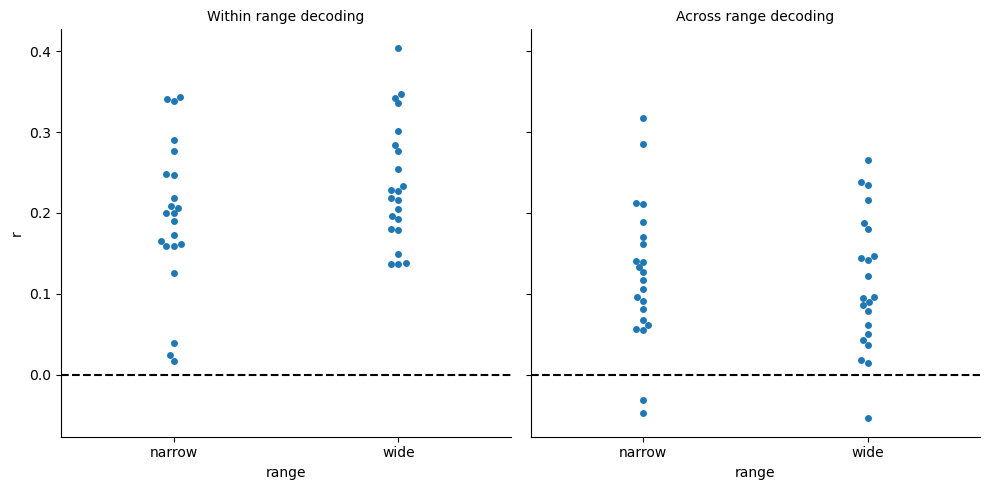

In [177]:
tmp = r_n.xs(True,0, 'smoothed').reset_index()

tmp['decoding_across'] = tmp['decoding_across'].map({True: 'Across range decoding', False: 'Within range decoding'})

g = sns.catplot(x='range', y='r', data=tmp, kind='swarm', col='decoding_across')

g.map(plt.axhline, y=0.0, c='k', ls='--')


# Change the titles to within/across (so map False to within and True to across)
g.set_titles('{col_name}')

In [142]:
r_n.groupby(['smoothed', 'range', 'decoding_across'])[['r']].mean()

r
smoothed range  decoding_across          
False    narrow False            0.335040
                True             0.170634
         wide   False            0.460553
                True             0.149660
True     narrow False            0.196862
                True             0.124454
         wide   False            0.235589
                True             0.113361

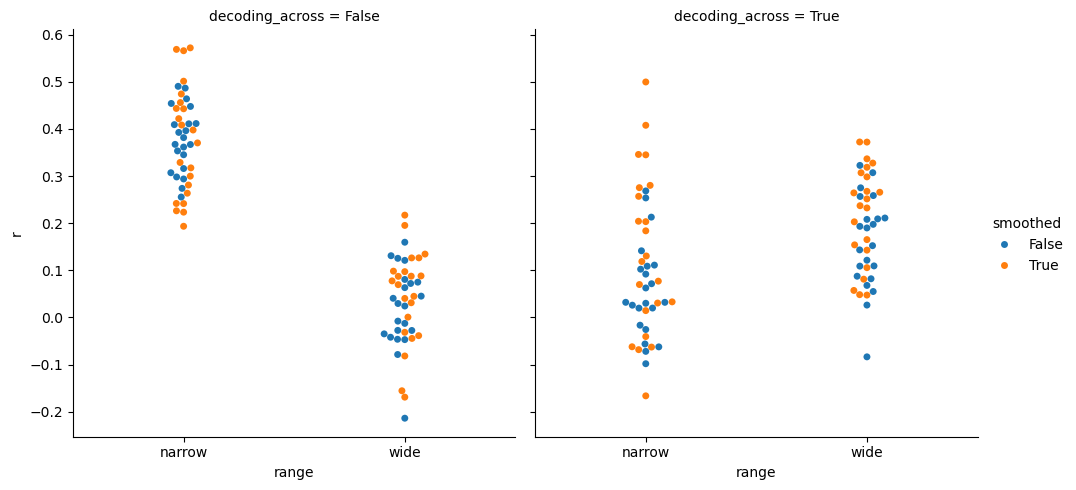

In [143]:
sns.catplot(x='range', y='r', data=r_error.reset_index(), kind='swarm', hue='smoothed', col='decoding_across')

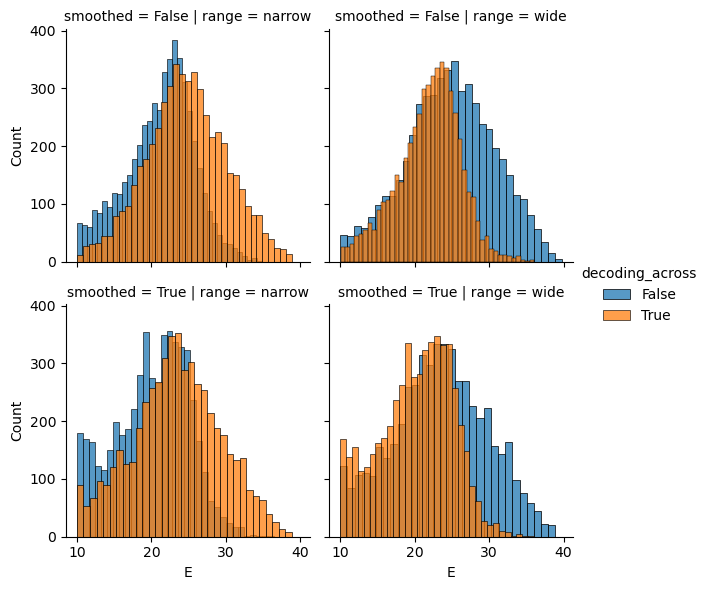

In [144]:
g = sns.FacetGrid(result.reset_index(), hue='decoding_across', col='range', row='smoothed')

g.map(sns.histplot, 'E')
g.add_legend()

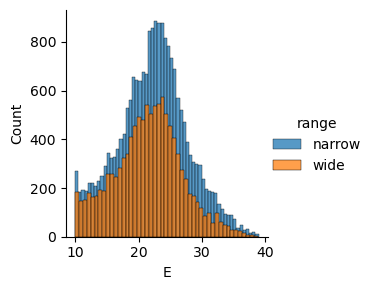

In [145]:
tmp = result[result.n < 26]

g = sns.FacetGrid(tmp.reset_index(), hue='range')

g.map(sns.histplot, 'E')
g.add_legend()

In [158]:
tmp

E        sd      error  \
subject range  n    decoding_across                                   
01      narrow 10.0 False            15.559894  4.701909   5.559894   
                    True             25.582703  5.496417  15.582703   
               11.0 False            14.773172  4.136773   3.773172   
                    True             23.355854  5.556214  12.355854   
               12.0 False            15.203498  4.915217   3.203498   
...                                        ...       ...        ...   
24      wide   38.0 True             23.042845  6.372575 -14.957155   
               39.0 False            27.801259  5.951495 -11.198741   
                    True             24.112311  6.719288 -14.887689   
               40.0 False            27.428824  5.646805 -12.571176   
                    True             21.289010  6.420404 -18.710990   

                                     abs(error)  
subject range  n    decoding_across              
01      narrow 10.0 False              5.559894  
                    True              15.582703  
               11.0 False              3.834754  
                    True              12.355854  
               12.0 False              3.331114  
...                                         ...  
24      wide   38.0 True              14.957155  
               39.0 False             11.198741  
                    True              14.887689  
               40.0 False             12.571176  
                    True              18.710990  

[2068 rows x 4 columns]

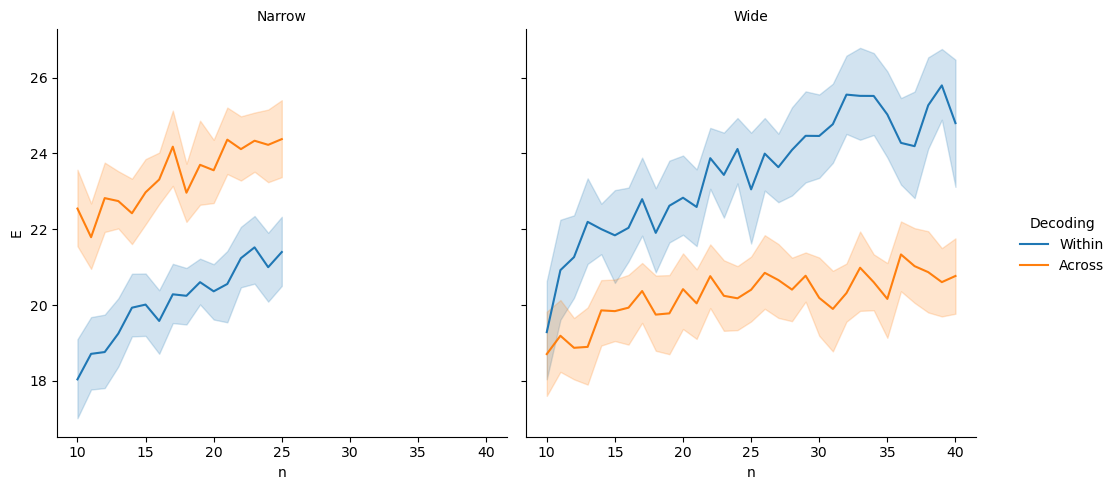

In [172]:
tmp = result.groupby(['subject', 'range', 'n', 'decoding_across', 'smoothed']).mean().xs(True, 0, 'smoothed').reset_index()


# Capitalize the range labels
tmp['range'] = tmp['range'].str.capitalize()

g = sns.relplot(x='n', y='E', data=tmp, hue='decoding_across', kind='line', col='range')

# Set title of each facet, capitalize first letter
g.set_titles('{col_name}')

# Set title of legend
g._legend.set_title('Decoding')

# Replace labels
new_labels = ['Within', 'Across']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

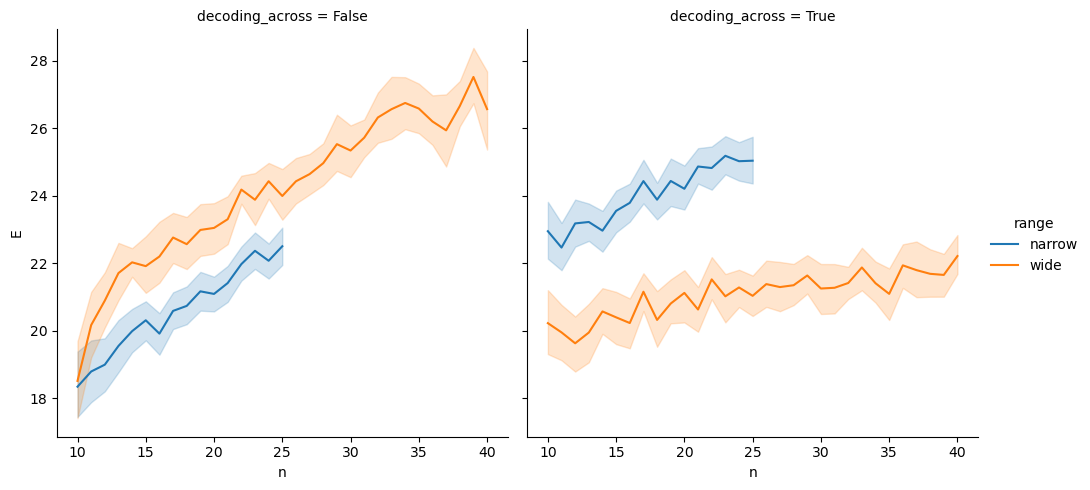

In [149]:
tmp = result.groupby(['subject', 'range', 'n', 'decoding_across']).mean()

sns.relplot(x='n', y='E', data=tmp.reset_index(), col='decoding_across', kind='line', hue='range')

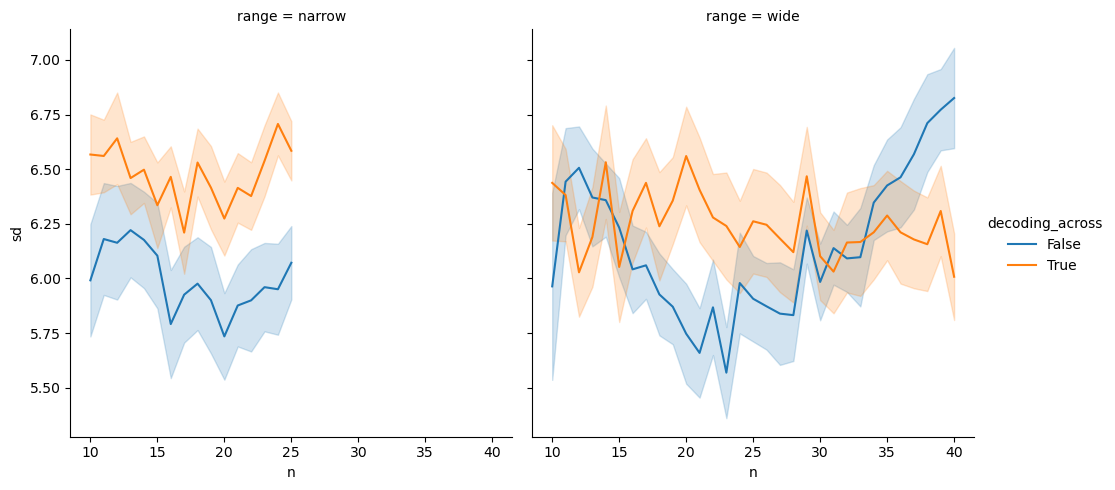

In [147]:
tmp = result.groupby(['subject', 'range', 'n', 'decoding_across']).mean()

sns.relplot(x='n', y='sd', data=tmp.reset_index(), hue='decoding_across', kind='line', col='range', errorbar='se')

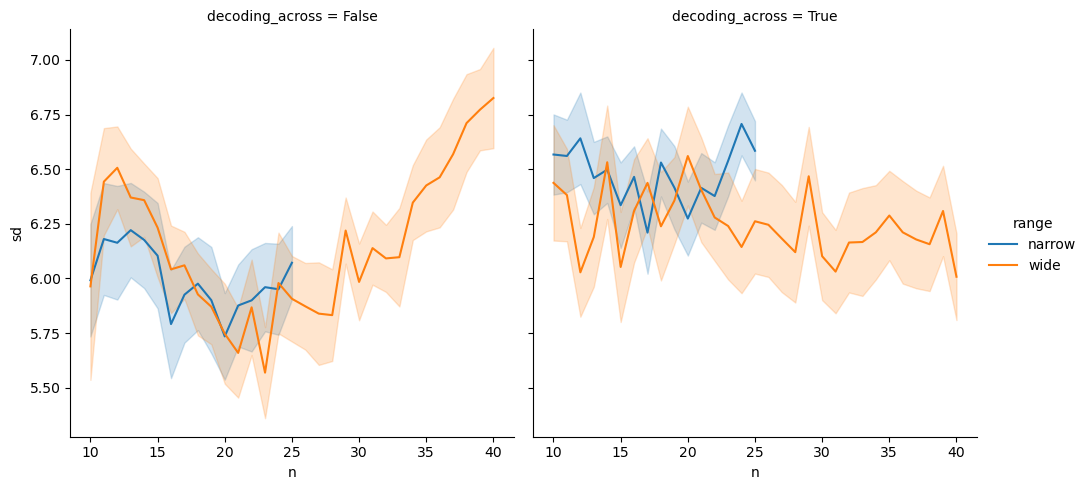

In [148]:
tmp = result.groupby(['subject', 'range', 'n', 'decoding_across']).mean()

sns.relplot(x='n', y='sd', data=tmp.reset_index(), hue='range', kind='line', col='decoding_across', 
            errorbar='se')

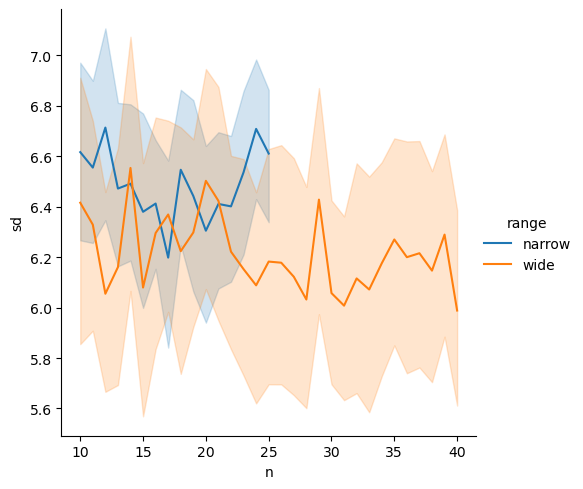

In [15]:
sns.relplot(x='n', y='sd', data=tmp.reset_index(), hue='range', kind='line')

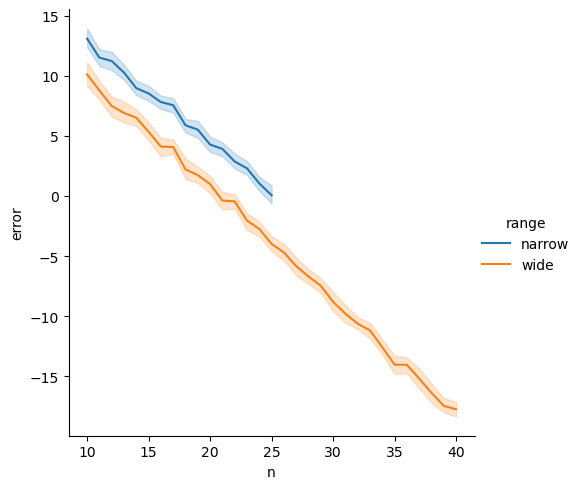

In [16]:
sns.relplot(x='n', y='error', data=tmp.reset_index(), hue='range', kind='line')

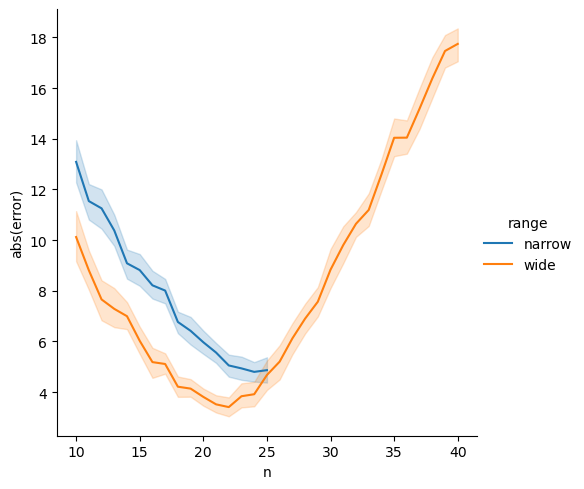

In [17]:
sns.relplot(x='n', y='abs(error)', data=tmp.reset_index(), hue='range', kind='line')

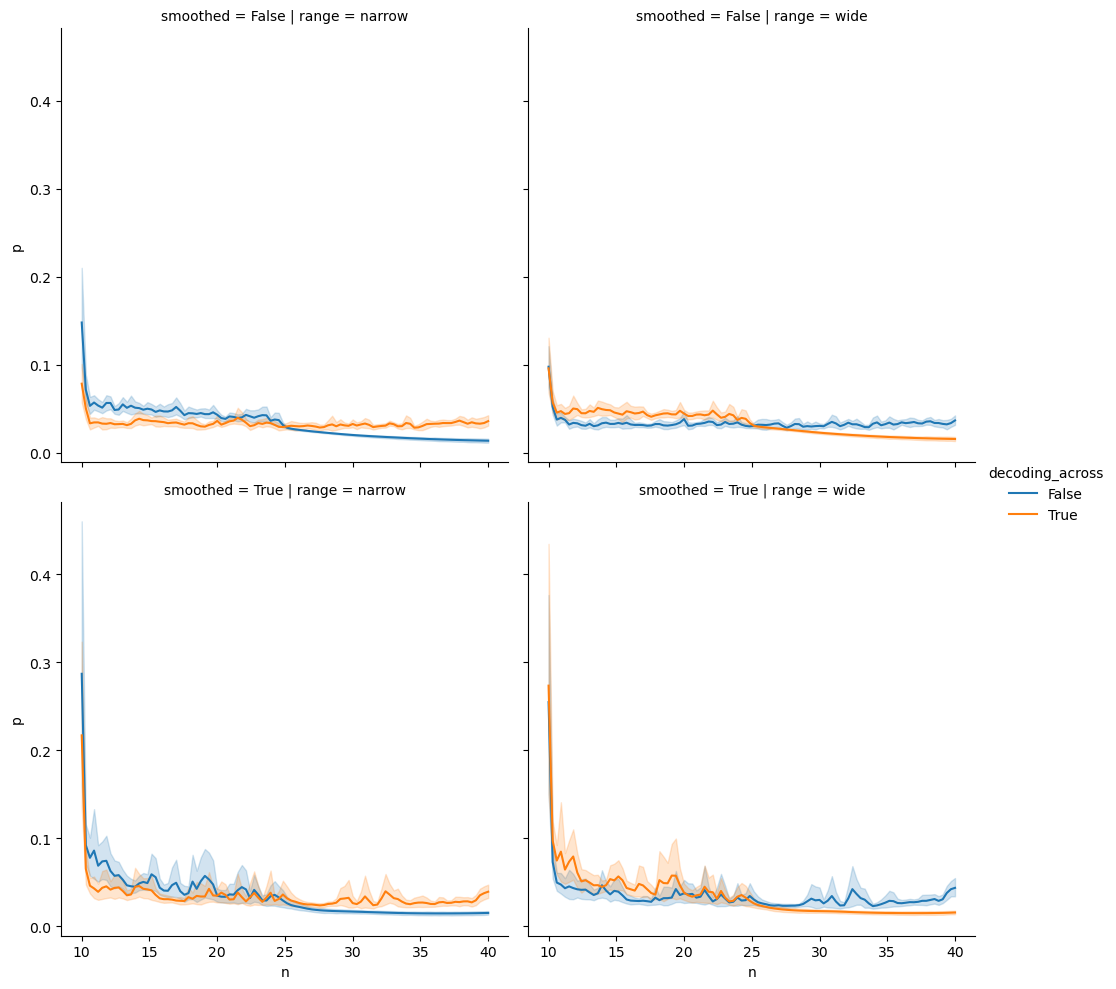

In [131]:
pdf.columns.name = 'n'
pdf.columns = pdf.columns.astype(float)
sns.relplot(x='n', y='p', hue='decoding_across', data=pdf.groupby(['subject', 'range', 'decoding_across', 'smoothed']).mean().stack().to_frame('p').reset_index(),
col='range',
            row='smoothed',
            kind='line')

<Axes: xlabel='n', ylabel='n'>

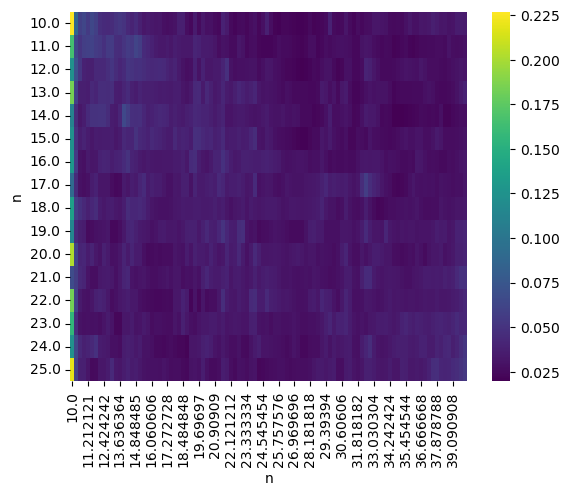

In [19]:
sns.heatmap(pdf.xs('narrow', level='range').groupby('n').mean(), cmap='viridis')

<Axes: xlabel='n', ylabel='n'>

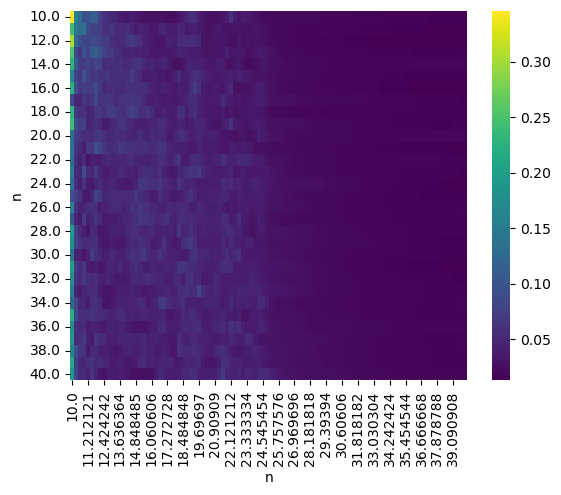

In [20]:
sns.heatmap(pdf.xs('wide', level='range').groupby('n').mean(), cmap='viridis')

In [21]:
pdf

n                                                     10.000000     10.303030  \
subject session run trial_nr range  smoothed n                                  
01      1       1   1        narrow False    11.0  4.324078e-03  2.033376e-03   
                                    True     11.0  4.542995e-05  5.266108e-05   
                    2        narrow False    23.0  2.888164e-06  1.217968e-05   
                                    True     23.0  2.473655e-07  3.744805e-07   
                    3        narrow False    23.0  5.776345e-06  2.656485e-05   
...                                                         ...           ...   
22      2       8   28       wide   True     37.0  1.422920e-03  3.269944e-03   
                    29       wide   False    34.0  4.308248e-06  7.454329e-06   
                                    True     34.0  7.104206e-05  1.515247e-04   
                    30       wide   False    12.0  6.358587e-05  7.891323e-05   
                                    True     12.0  2.211817e-04  3.789479e-04   

n                                                     10.606061     10.909091  \
subject session run trial_nr range  smoothed n                                  
01      1       1   1        narrow False    11.0  3.836900e-04  8.308775e-05   
                                    True     11.0  1.801456e-04  1.051884e-03   
                    2        narrow False    23.0  1.656454e-05  2.258962e-05   
                                    True     23.0  5.671072e-07  5.384359e-07   
                    3        narrow False    23.0  3.728224e-05  4.416176e-05   
...                                                         ...           ...   
22      2       8   28       wide   True     37.0  7.200043e-03  1.501351e-02   
                    29       wide   False    34.0  1.319361e-05  2.401078e-05   
                                    True     34.0  3.269998e-04  7.032299e-04   
                    30       wide   False    12.0  9.960053e-05  1.296778e-04   
                                    True     12.0  6.606037e-04  1.165791e-03   

n                                                     11.212121  11.515152  \
subject session run trial_nr range  smoothed n                               
01      1       1   1        narrow False    11.0  3.410903e-05   0.000026   
                                    True     11.0  8.906132e-04   0.000008   
                    2        narrow False    23.0  4.722399e-05   0.000069   
                                    True     23.0  6.447775e-07   0.000001   
                    3        narrow False    23.0  6.286715e-05   0.000066   
...                                                         ...        ...   
22      2       8   28       wide   True     37.0  2.934416e-02   0.053256   
                    29       wide   False    34.0  4.505905e-05   0.000087   
                                    True     34.0  1.484960e-03   0.003034   
                    30       wide   False    12.0  1.765090e-04   0.000254   
                                    True     12.0  2.070556e-03   0.003674   

n                                                     11.818182  12.121212  \
subject session run trial_nr range  smoothed n                               
01      1       1   1        narrow False    11.0  4.102674e-05   0.000068   
                                    True     11.0  3.573923e-07   0.000009   
                    2        narrow False    23.0  3.079072e-05   0.000005   
                                    True     23.0  1.116918e-06   0.000001   
                    3        narrow False    23.0  8.012907e-05   0.000128   
...                                                         ...        ...   
22      2       8   28       wide   True     37.0  8.895722e-02   0.135654   
                    29       wide   False    34.0  1.721606e-04   0.000344   
                                    True     34.0  5.914997e-03   0.010852   
                   

In [22]:
pdf.columns = pdf.columns.astype(float)

In [33]:
pdf_cut = pdf.loc[:, :25]
pdf_cut = pdf_cut.xs(slice(0, 26), 0, level='n', drop_level=False)

E_low = np.trapz(pdf_cut.values*pdf_cut.columns.values[np.newaxis, :], pdf_cut.columns.values, axis=1)
sd_low = np.trapz(pdf_cut.values*(pdf_cut.columns.values[np.newaxis, :] - E_low[:, np.newaxis])**2, pdf_cut.columns.values, axis=1)**0.5

E_low = pd.Series(E_low, index=pdf_cut.index)
sd_low = pd.Series(sd_low, index=pdf_cut.index)

results_low = E_low.to_frame('E').join(sd_low.to_frame('sd')).reset_index('n')

pdf_cut /= np.trapz(pdf_cut.values, pdf_cut.columns.values, axis=1)[:, np.newaxis]

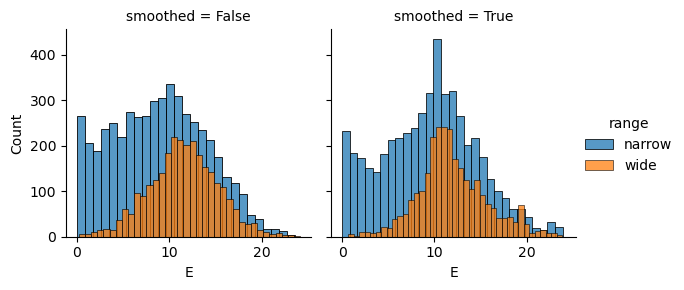

In [34]:
g = sns.FacetGrid(results_low.reset_index(), hue='range', col='smoothed')

g.map(sns.histplot, 'E')
g.add_legend()

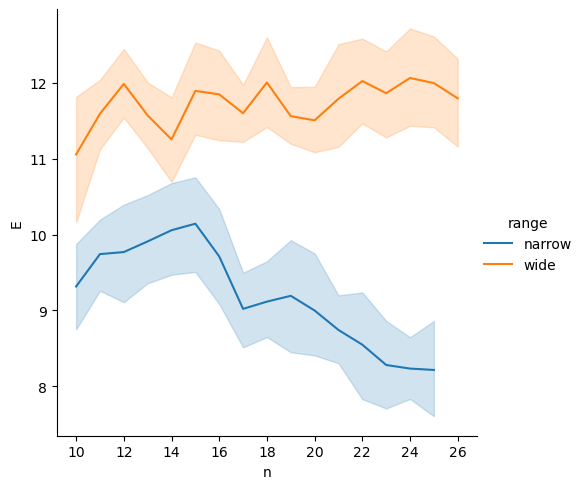

In [35]:
tmp = results_low.groupby(['subject', 'range', 'n']).mean()

sns.relplot(x='n', y='E', data=tmp.reset_index(), hue='range', kind='line')

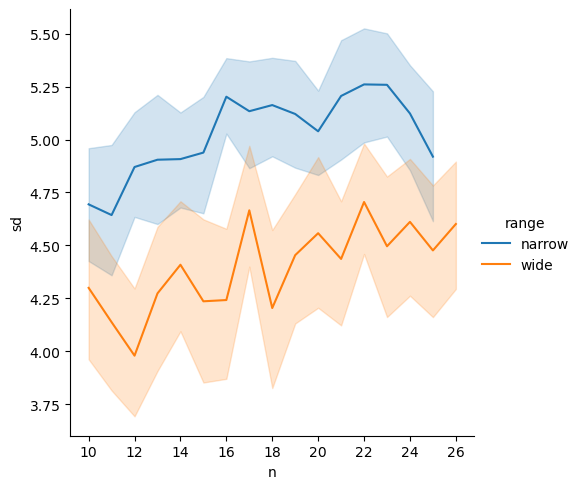

In [36]:
tmp = results_low.groupby(['subject', 'range', 'n']).mean()

sns.relplot(x='n', y='sd', data=tmp.reset_index(), hue='range', kind='line')

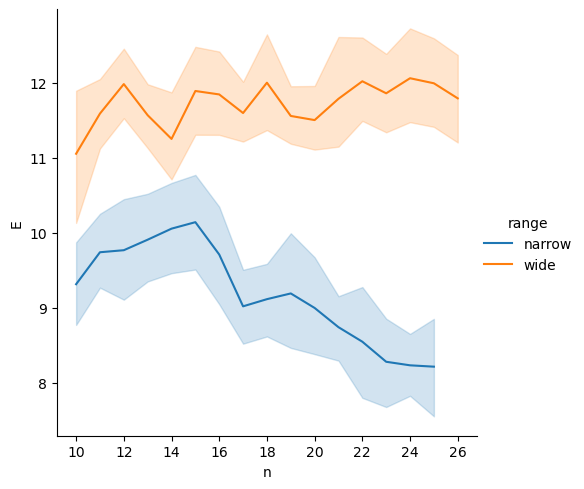

In [39]:
tmp = results_low.groupby(['subject', 'range', 'n']).mean()

sns.relplot(x='n', y='E', data=tmp.reset_index(), hue='range', kind='line')

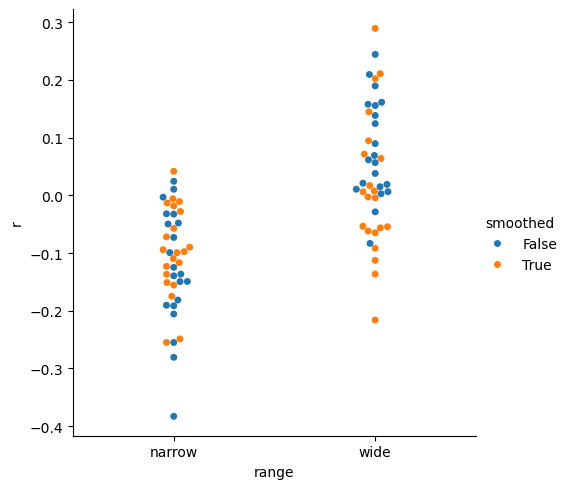

In [38]:
sns.catplot(x='range', y='r', data=r_n.reset_index(), kind='swarm', hue='smoothed')

In [102]:
r_n

n         r          CI95%  \
subject range  smoothed decoding_across                                         
01      narrow False    False           pearson  240  0.493659   [0.39, 0.58]   
                        True            pearson  240  0.116476  [-0.01, 0.24]   
               True     False           pearson  240  0.024188   [-0.1, 0.15]   
                        True            pearson  240  0.090471  [-0.04, 0.21]   
        wide   False    False           pearson  240  0.533527   [0.44, 0.62]   
...                                              ...       ...            ...   
22      narrow True     True            pearson  240  0.133153   [0.01, 0.26]   
        wide   False    False           pearson  240  0.513315    [0.41, 0.6]   
                        True            pearson  240  0.182789    [0.06, 0.3]   
               True     False           pearson  240  0.346818   [0.23, 0.45]   
                        True            pearson  240  0.266059   [0.14, 0.38]   

                                                        p-val       BF10  \
subject range  smoothed decoding_across                                    
01      narrow False    False           pearson  3.793128e-16  1.673e+13   
                        True            pearson  7.167793e-02      0.405   
               True     False           pearson  7.092831e-01      0.087   
                        True            pearson  1.623784e-01      0.213   
        wide   False    False           pearson  4.668952e-19  1.193e+16   
...                                                       ...        ...   
22      narrow True     True            pearson  3.928246e-02      0.667   
        wide   False    False           pearson  1.555895e-17  3.826e+14   
                        True            pearson  4.497984e-03      4.459   
               True     False           pearson  3.448098e-08  2.992e+05   
                        True            pearson  2.969832e-05    468.281   

                                                    power  
subject range  smoothed decoding_across                    
01      narrow False    False           pearson  1.000000  
                        True            pearson  0.438305  
               True     False           pearson  0.066025  
                        True            pearson  0.287781  
        wide   False    False           pearson  1.000000  
...                                                   ...  
22      narrow True     True            pearson  0.542183  
        wide   False    False           pearson  1.000000  
                        True            pearson  0.813627  
               True     False           pearson  0.999853  
                        True            pearson  0.987614  

[168 rows x 6 columns]

,n,r,CI95%,p-val,BF10,power
pearson,21,-0.467335,"[-0.75, -0.04]",0.032672,2.294,0.592155


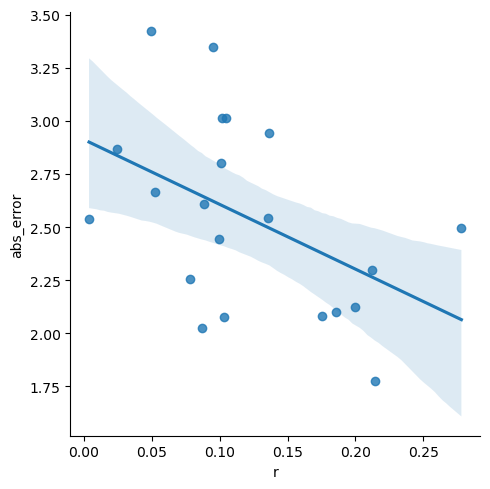

In [124]:
r_ = r_n.xs(True, 0, 'smoothed').xs(True, 0, 'decoding_across').groupby('subject')['r'].mean()

tmp = r_.to_frame().join(behavior).groupby(['subject'])[['r', 'abs_error']].mean()
sns.lmplot(x='r', y='abs_error', data=tmp.reset_index())

pg.corr(tmp['r'], tmp['abs_error'])

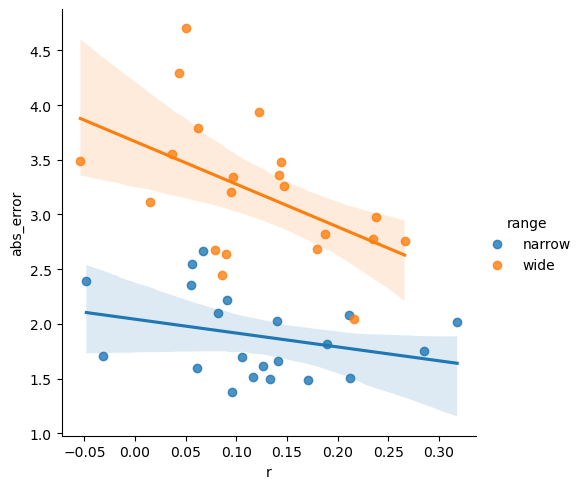

In [118]:
r_ = r_n.xs(True, 0, 'smoothed').xs(True, 0, 'decoding_across').groupby(['subject', 'range'])['r'].mean()

tmp = r_.to_frame().join(behavior.set_index('range', append=True)).groupby(['subject', 'range'])[['r', 'abs_error']].mean()
sns.lmplot(x='r', y='abs_error', data=tmp.reset_index(), hue='range')

In [121]:
tmp.groupby('range').apply(lambda d: pg.corr(d['r'], d['abs_error']))

,,n,r,CI95%,p-val,BF10,power
range,,,,,,,
narrow,pearson,21,-0.298004,"[-0.65, 0.15]",0.189502,0.606,0.264637
wide,pearson,21,-0.506055,"[-0.77, -0.1]",0.019250,3.52,0.674552
